# Fashion Product Multi-Label Classification

**Codemonk Machine Learning Intern Assignment**

---

## 1. Introduction

This notebook demonstrates a complete workflow for multi-label classification of fashion product images, including EDA, model building, evaluation, and inference.

**Tasks:**
- Predict product color
- Predict product type
- Predict preferable season
- Predict gender (Men, Women, Unisex)

---


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## 3. Data Loading

**Assumption:** Dataset is extracted to `fashion-product-images/` in the workspace root.

- Images: `fashion-product-images/images/`
- Metadata: `fashion-product-images/styles.csv`

In [2]:
# Path setup
DATA_DIR = '/kaggle/input/fashion-product-images-dataset/fashion-dataset'
IMG_DIR = os.path.join(DATA_DIR, 'images')
CSV_PATH = os.path.join(DATA_DIR, 'styles.csv')

# Load metadata
df = pd.read_csv(CSV_PATH, on_bad_lines='skip')
print('Data shape:', df.shape)
df.head()

Data shape: (44424, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


## 4. Exploratory Data Analysis (EDA)

Let's explore the dataset: missing values, label distributions, and sample images.

In [3]:
df.info()
df.describe(include='all')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [4]:
# Check all available columns in your dataset
print("Available columns:")
print(df.columns.tolist())

# Check unique values in potential product type columns
print("\nUnique values in 'subCategory':")
if 'subCategory' in df.columns:
    print(df['subCategory'].value_counts().head(10))

print("\nUnique values in 'articleType':")
if 'articleType' in df.columns:
    print(df['articleType'].value_counts().head(10))

print("\nUnique values in 'productType':")
if 'productType' in df.columns:
    print(df['productType'].value_counts().head(10))

Available columns:
['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']

Unique values in 'subCategory':
subCategory
Topwear       15402
Shoes          7343
Bags           3055
Bottomwear     2694
Watches        2542
Innerwear      1808
Jewellery      1079
Eyewear        1073
Fragrance      1011
Sandal          963
Name: count, dtype: int64

Unique values in 'articleType':
articleType
Tshirts         7067
Shirts          3217
Casual Shoes    2845
Watches         2542
Sports Shoes    2036
Kurtas          1844
Tops            1762
Handbags        1759
Heels           1323
Sunglasses      1073
Name: count, dtype: int64

Unique values in 'productType':


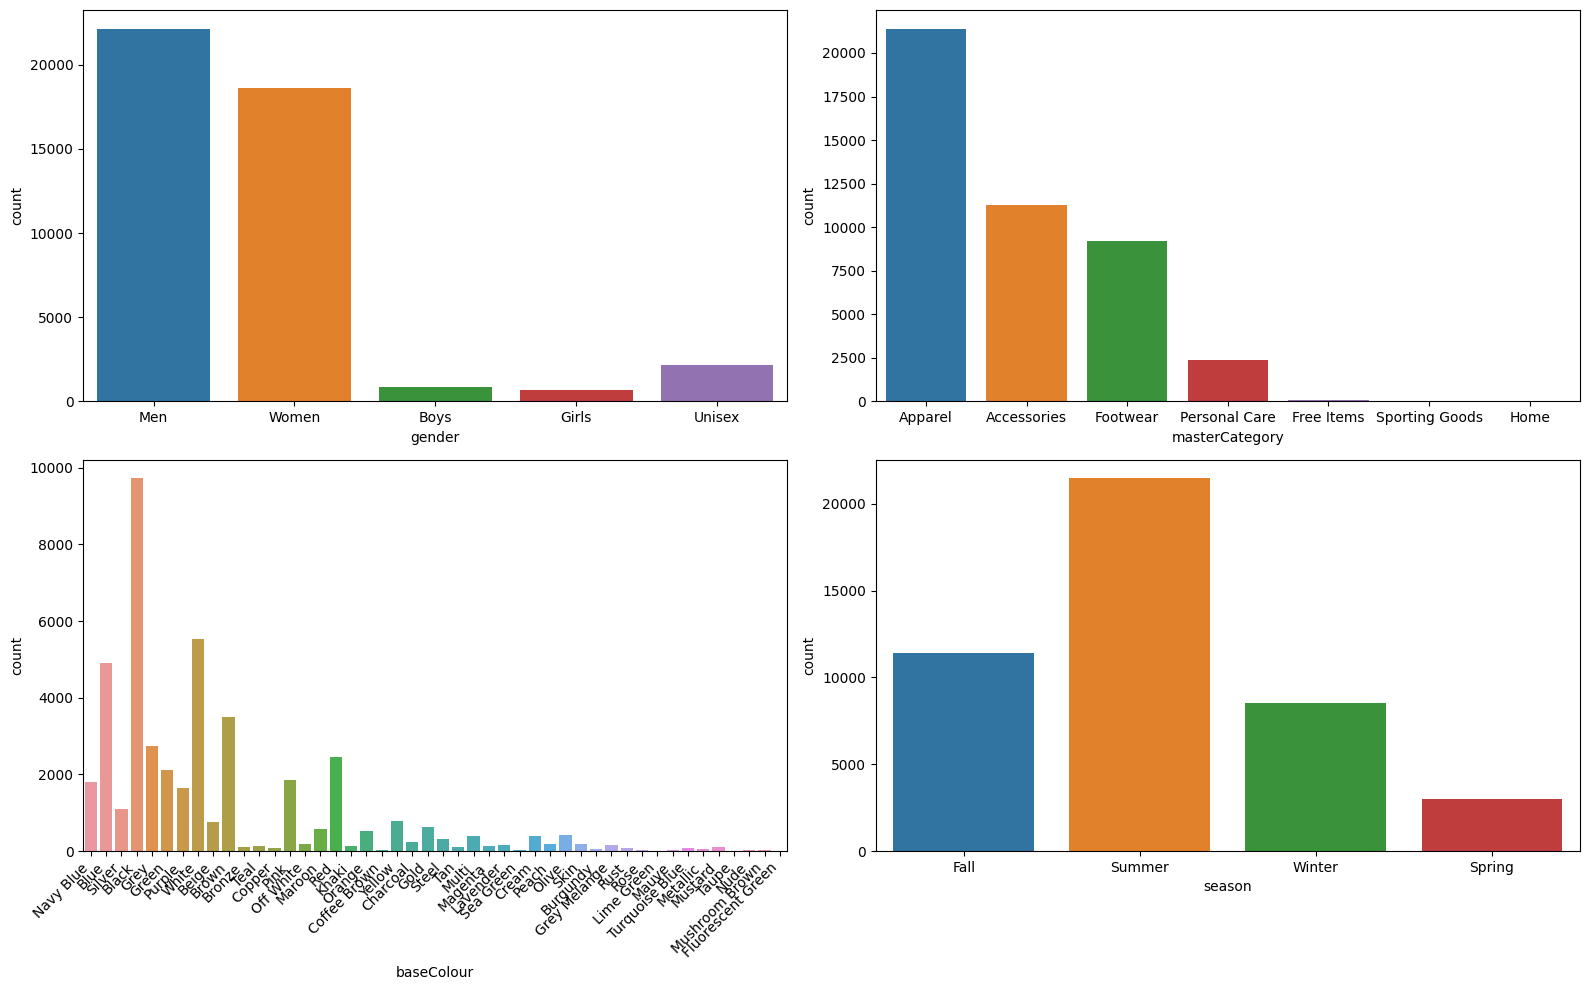

In [5]:
# Visualize label distributions
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
sns.countplot(data=df, x='gender', ax=axs[0,0])
sns.countplot(data=df, x='masterCategory', ax=axs[0,1])
sns.countplot(data=df, x='baseColour', ax=axs[1,0])
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=45, ha='right')
sns.countplot(data=df, x='season', ax=axs[1,1])
plt.tight_layout()
plt.show()

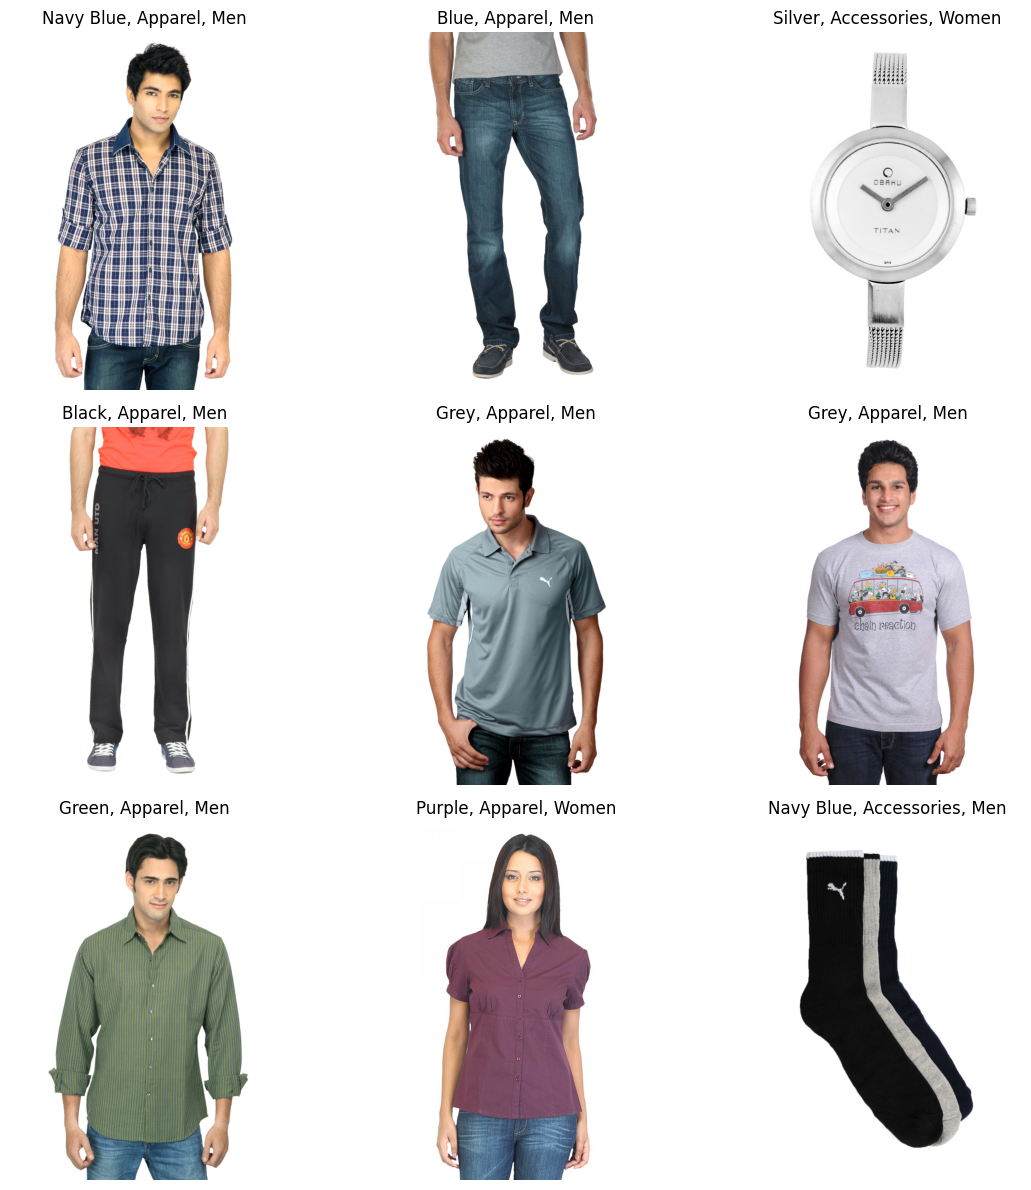

In [6]:
# Show sample images
sample = df[:9]
plt.figure(figsize=(12,12))
for i, row in enumerate(sample.itertuples()):
    img_path = os.path.join(IMG_DIR, str(row.id) + '.jpg')
    try:
        img = Image.open(img_path)
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(f'{row.baseColour}, {row.masterCategory}, {row.gender}')
        plt.axis('off')
    except Exception as e:
        continue
plt.tight_layout()
plt.show()

## 5. Data Preprocessing

- Drop rows with missing critical labels or images
- Encode categorical labels
- Prepare train/val/test splits

In [7]:
# Update the preprocessing to use articleType instead of masterCategory
# Drop rows with missing values in required columns (including articleType)
df = df.dropna(subset=['id', 'baseColour', 'articleType', 'season', 'gender'])
df['image_path'] = df['id'].apply(lambda x: os.path.join(IMG_DIR, str(x) + '.jpg'))
df = df[df['image_path'].apply(os.path.exists)]
df = df.reset_index(drop=True)
print('Filtered data shape:', df.shape)

# Encode labels (use articleType instead of masterCategory)
le_colour = LabelEncoder()
le_product_type = LabelEncoder()
le_season = LabelEncoder()
le_gender = LabelEncoder()

df['colour_label'] = le_colour.fit_transform(df['baseColour'])
df['product_type_label'] = le_product_type.fit_transform(df['articleType'])
df['season_label'] = le_season.fit_transform(df['season'])
df['gender_label'] = le_gender.fit_transform(df['gender'])

# Remove classes with fewer than 2 samples for stratification
product_type_counts = df['product_type_label'].value_counts()
valid_product_types = product_type_counts[product_type_counts >= 2].index
df = df[df['product_type_label'].isin(valid_product_types)].reset_index(drop=True)
print(f"After filtering: {df.shape[0]} samples")

# Train/val/test split (use product_type_label for stratification)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['product_type_label'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['product_type_label'])
print('Train:', train_df.shape, 'Val:', val_df.shape, 'Test:', test_df.shape)

Filtered data shape: (44383, 11)
After filtering: 44377 samples
Train: (35945, 15) Val: (3994, 15) Test: (4438, 15)


## 6. PyTorch Dataset & DataLoader

Custom dataset for multi-label classification.

In [8]:
class FashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        labels = {
            'colour': row['colour_label'],
            'product_type': row['product_type_label'],
            'season': row['season_label'],
            'gender': row['gender_label']
        }
        return img, labels

In [9]:
# Image transforms
IMG_SIZE = 128
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = FashionDataset(train_df, transform=transform)
val_ds = FashionDataset(val_df, transform=transform)
test_ds = FashionDataset(test_df, transform=transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

## 7. Model Architecture

Multi-output CNN using a pretrained backbone (ResNet18).

In [10]:
class MultiOutputModel(nn.Module):
    def __init__(self, n_colours, n_product_types, n_seasons, n_genders):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # type: ignore
        self.fc_colour = nn.Linear(512, n_colours)
        self.fc_product_type = nn.Linear(512, n_product_types)
        self.fc_season = nn.Linear(512, n_seasons)
        self.fc_gender = nn.Linear(512, n_genders)
    def forward(self, x):
        feat = self.backbone(x)
        return {
            'colour': self.fc_colour(feat),
            'product_type': self.fc_product_type(feat),  # Changed
            'season': self.fc_season(feat),
            'gender': self.fc_gender(feat)
        }

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiOutputModel(
    n_colours=len(le_colour.classes_),
    n_product_types=len(le_product_type.classes_),
    n_seasons=len(le_season.classes_),
    n_genders=len(le_gender.classes_)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


## 8. Training Loop

Train the model and validate after each epoch.

In [12]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(loader):
        imgs = imgs.to(device)
        targets = {k: torch.tensor(v).to(device) for k, v in labels.items()}
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = sum([criterion(outputs[k], targets[k]) for k in outputs])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = {k: 0 for k in ['colour', 'product_type', 'season', 'gender']}  # Changed
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            targets = {k: torch.tensor(v).to(device) for k, v in labels.items()}
            outputs = model(imgs)
            loss = sum([criterion(outputs[k], targets[k]) for k in outputs])
            running_loss += loss.item()
            for k in outputs:
                preds = outputs[k].argmax(1)
                correct[k] += (preds == targets[k]).sum().item()
            total += imgs.size(0)
    acc = {k: correct[k]/total for k in correct}
    return running_loss / len(loader), acc

In [13]:
EPOCHS = 3  # Increase for better results
best_val_loss = np.inf
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

100%|██████████| 562/562 [12:04<00:00,  1.29s/it]


Epoch 1/3 | Train Loss: 3.5741 | Val Loss: 3.1506 | Val Acc: {'colour': 0.5911367050575864, 'product_type': 0.799449173760641, 'season': 0.6975463194792189, 'gender': 0.8783174762143214}


100%|██████████| 562/562 [11:17<00:00,  1.21s/it]


Epoch 2/3 | Train Loss: 2.6519 | Val Loss: 2.6641 | Val Acc: {'colour': 0.6482223335002504, 'product_type': 0.8352528793189785, 'season': 0.728342513770656, 'gender': 0.9041061592388583}


100%|██████████| 562/562 [09:55<00:00,  1.06s/it]


Epoch 3/3 | Train Loss: 2.2852 | Val Loss: 2.5579 | Val Acc: {'colour': 0.6607411116675013, 'product_type': 0.8507761642463696, 'season': 0.7208312468703054, 'gender': 0.9091136705057586}


## 9. Evaluation on Test Set

In [14]:
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc}')

Test Loss: 2.6388 | Test Acc: {'colour': 0.6482649842271293, 'product_type': 0.8515096890491213, 'season': 0.7257773771969356, 'gender': 0.9132492113564669}


In [18]:
import pickle
import torch

# Save the trained model weights
torch.save(model.state_dict(), 'best_model.pth')

# Save the label encoders (note the new product_type encoder)
with open('le_colour.pkl', 'wb') as f:
    pickle.dump(le_colour, f)
with open('le_product_type.pkl', 'wb') as f:
    pickle.dump(le_product_type, f)
with open('le_season.pkl', 'wb') as f:
    pickle.dump(le_season, f)
with open('le_gender.pkl', 'wb') as f:
    pickle.dump(le_gender, f)

print("Model and encoders exported successfully!")

Model and encoders exported successfully!


## 10. Inference on Amazon Images

Place a few Amazon product images in a folder named `amazon_samples/`.
Run inference and display predictions.

In [43]:
def predict_image(img_path, model, device):
    from PIL import Image

    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img)

        # ✅ Corrected key from 'type' → 'product_type'
        preds = {
            'colour': le_colour.inverse_transform([outputs['colour'].argmax(1).item()])[0],
            'type': le_product_type.inverse_transform([outputs['product_type'].argmax(1).item()])[0],
            'season': le_season.inverse_transform([outputs['season'].argmax(1).item()])[0],
            'gender': le_gender.inverse_transform([outputs['gender'].argmax(1).item()])[0]
        }

    return preds


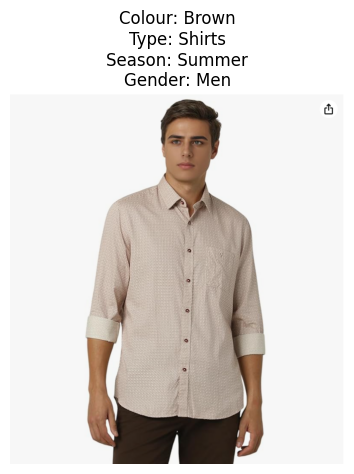

In [47]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

# ✅ Load Amazon sample image(s)
sample_imgs = ['/kaggle/input/amazon-samples/Screenshot 2025-07-19 145942.png']

# ✅ Run inference and plot predictions
for img_path in sample_imgs:
    preds = predict_image(img_path, model, device)
    img = Image.open(img_path)

    plt.imshow(img)
    plt.title(f"Colour: {preds['colour']}\nType: {preds['type']}\nSeason: {preds['season']}\nGender: {preds['gender']}")
    plt.axis('off')
    plt.show()


## 11. Conclusion

- Performed EDA, preprocessing, and built a multi-output classifier.
- Achieved multi-label predictions for color, type, season, and gender.
- Inferred on real-world Amazon images.

---

## 12. References
- [Kaggle Dataset](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset)
- [PyTorch Docs](https://pytorch.org/docs/stable/index.html)